In [39]:
# Imports
import tensorflow as tf 
import pandas as pd 
import numpy as np 
from attention import Attention
import matplotlib.pyplot as plt
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

# Stock API Lib
from alpha_vantage.timeseries import TimeSeries

# News Api
from stocknews import StockNews

In [2]:
"""
Basic concept of the project:
    Using news and time series forecasting we try to predict if a stock goes up at time t given the previous t-1 timepoints.
    We will use a LSTM model with attention layers. 
    To remove the noise from the data we will use wavelet transformation. 

Task to get this working:
    - Build an API to get historical stock data 
    - Scrap historical stock News and calculate the polarization // Not done yet
    - Build a fitting LSMT model with attention 
    - Train the model 
    - Evaluate the performance against baseline models f.e normal LSTM without attatention and news // Not done yet
"""

'\nBasic concept of the project:\n    Using news and time series forecasting we try to predict the close price t+1 of a stock given 1-t timepoints.\n    We will use a LSTM model with attention layers. \n    To remove the noise from the data we will use wavelet transformation. \n\nTask to get this working:\n    - Build an API to get historical stock data \n    - Scrap historical stock News and calculate the polarization\n    - Build a fitting LSMT model with attention \n    - Train the model \n    - Evaluate the performance against baseline models f.e normal LSTM without attatention and news  \n'

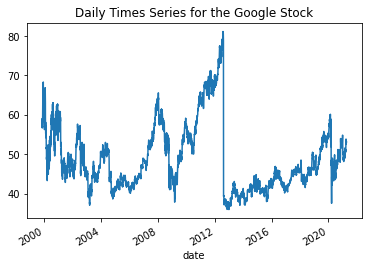

            1. open  2. high  3. low  4. close   5. volume
date                                                      
2021-04-08    53.17   53.380  52.970     53.12   9693904.0
2021-04-07    53.28   53.500  53.120     53.28  10062687.0
2021-04-06    53.04   53.650  52.900     53.19  15614268.0
2021-04-05    52.35   53.215  52.290     52.81  16368724.0
2021-04-01    52.96   53.150  52.455     52.51  15834732.0


In [46]:
# Fetch stock data using Alpha_vantage API Wrapper
api_key = ''

ts = TimeSeries(key=api_key, output_format='pandas')
df, meta_data = ts.get_daily(symbol='KO', outputsize='full')
df['4. close'].plot()
plt.title('Daily Times Series for the Google Stock')
plt.show()
print(df.head())

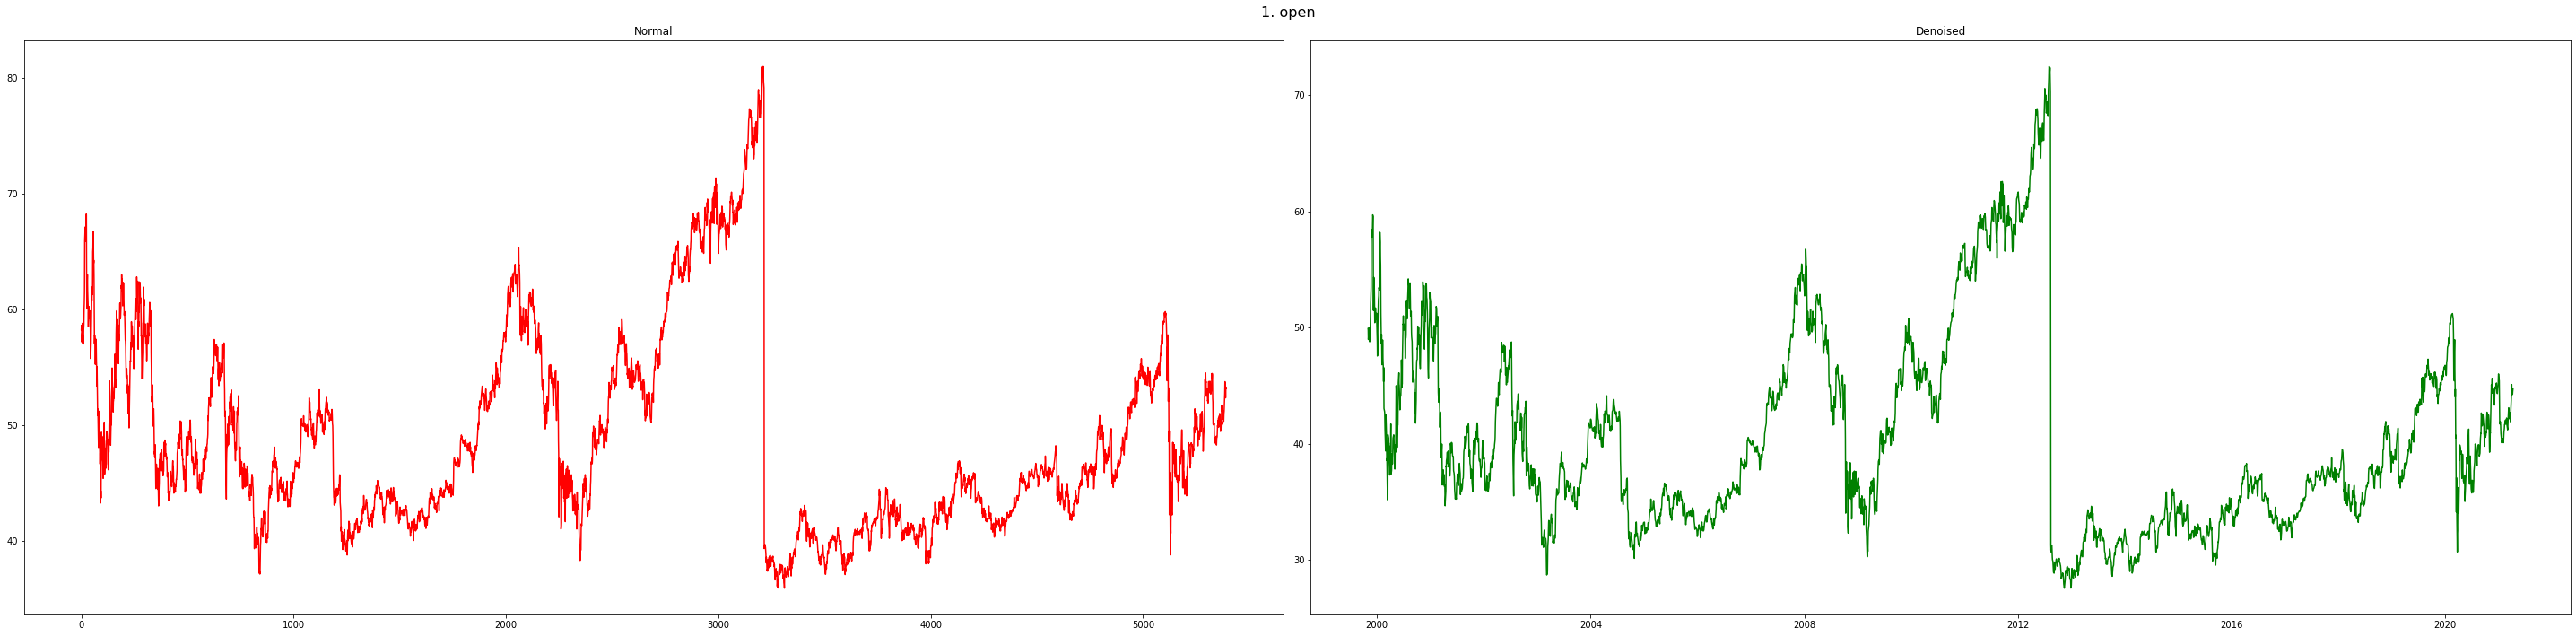

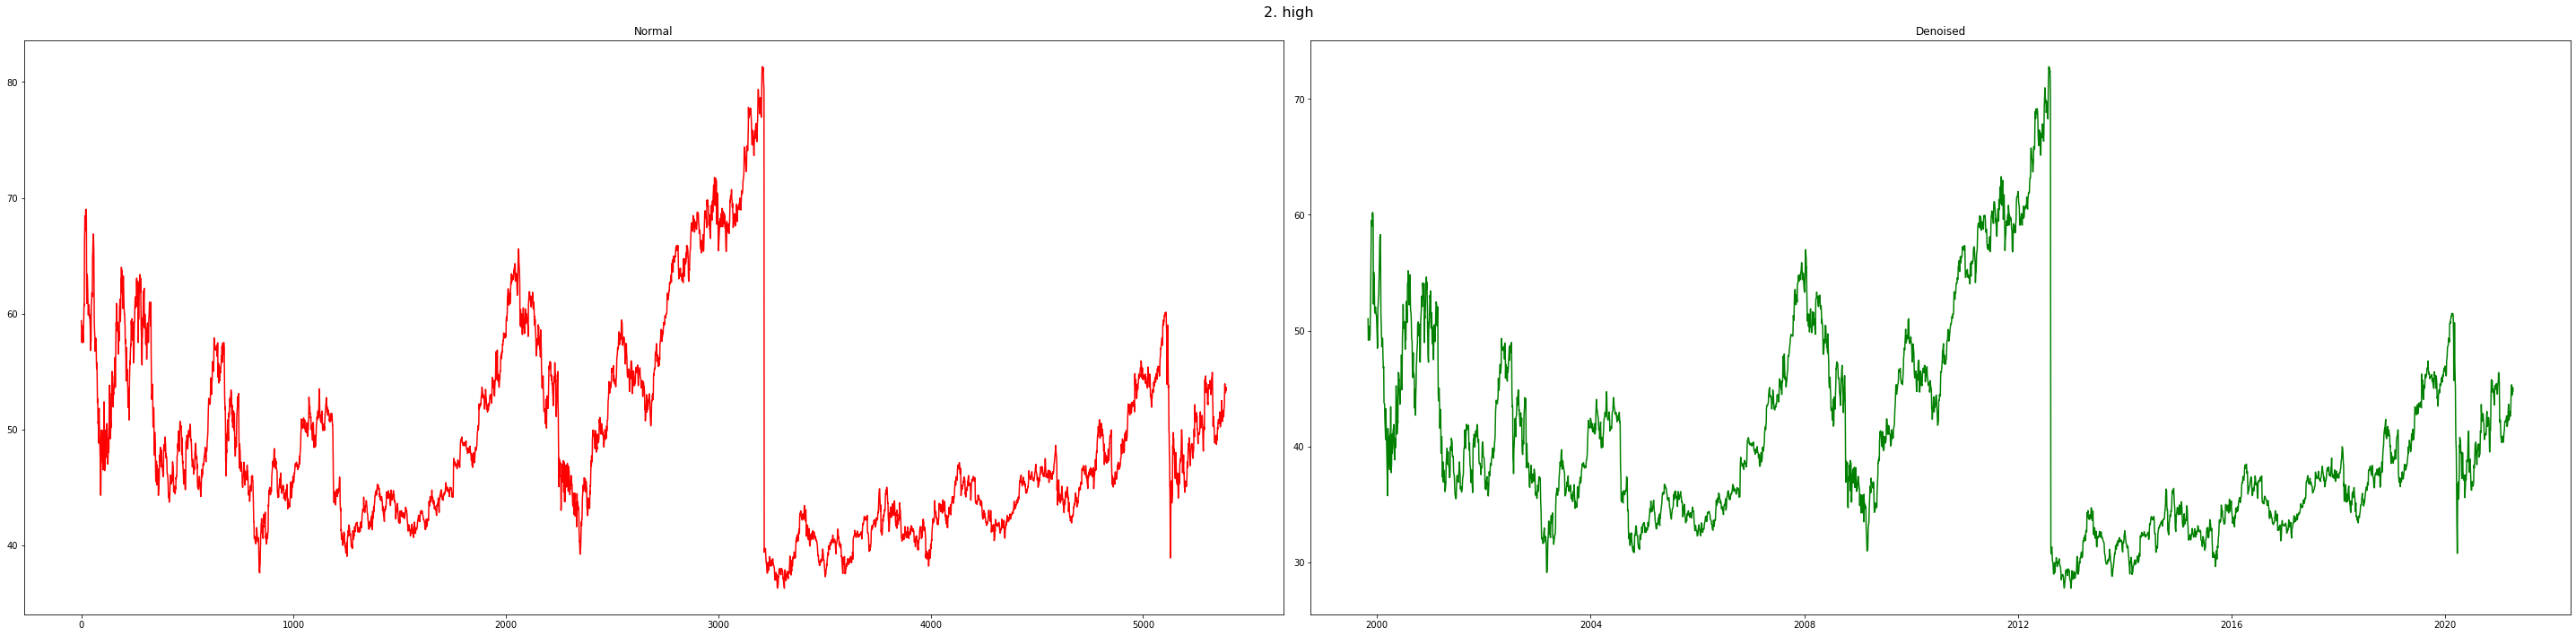

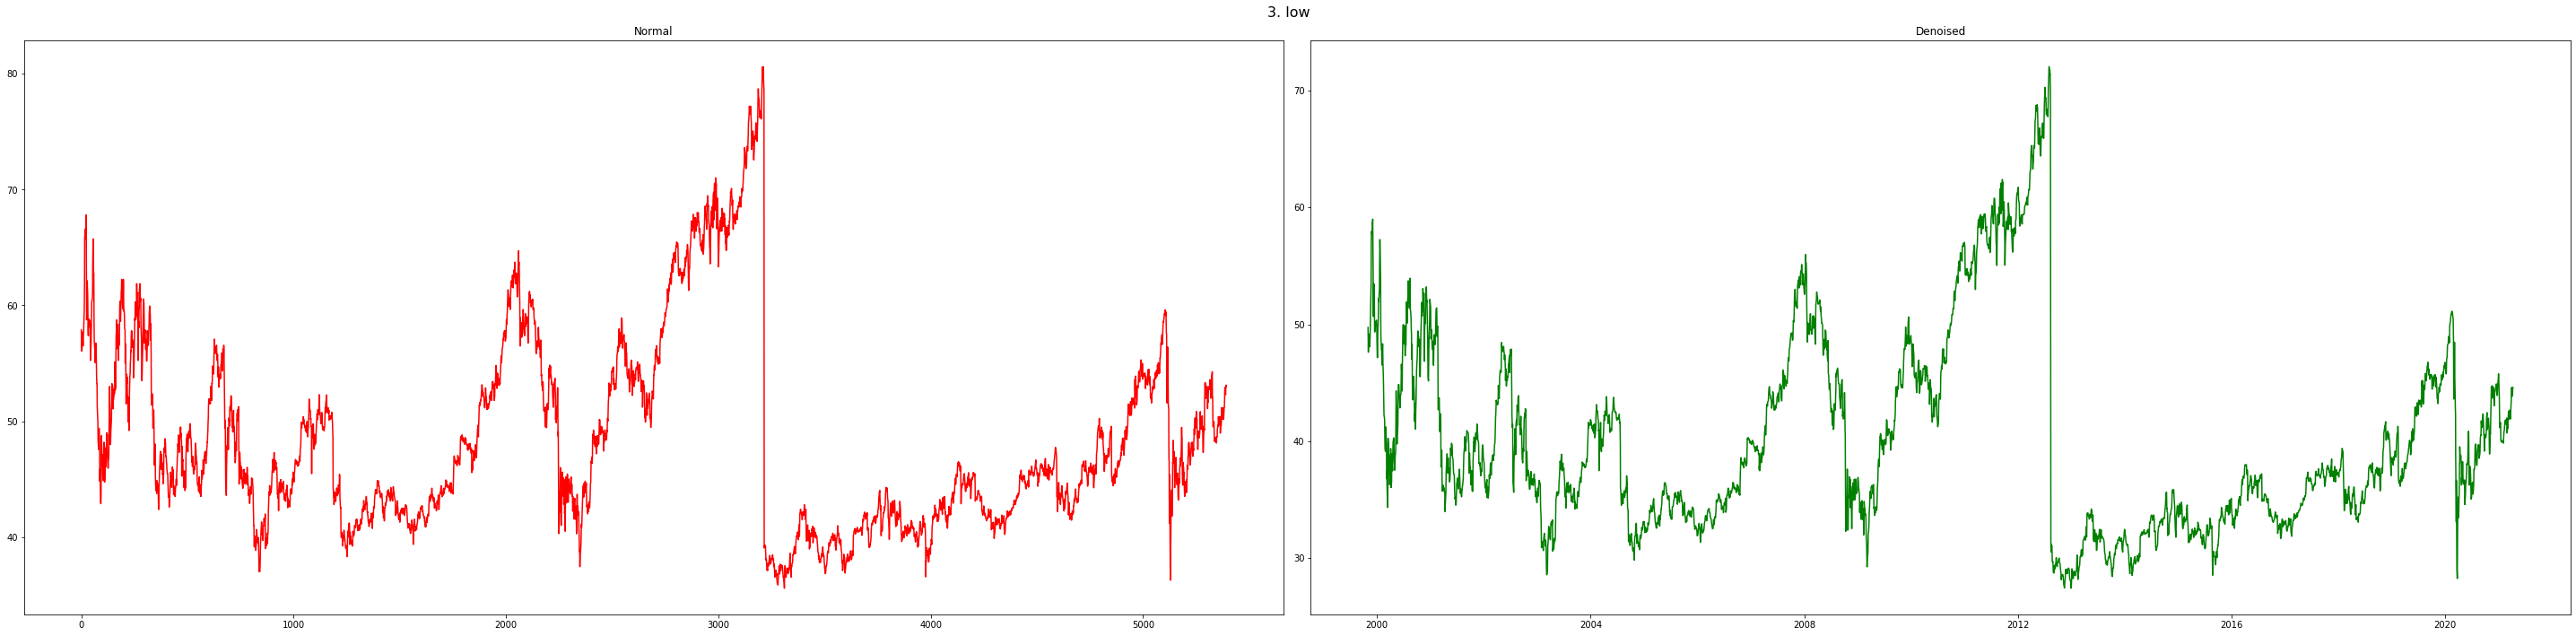

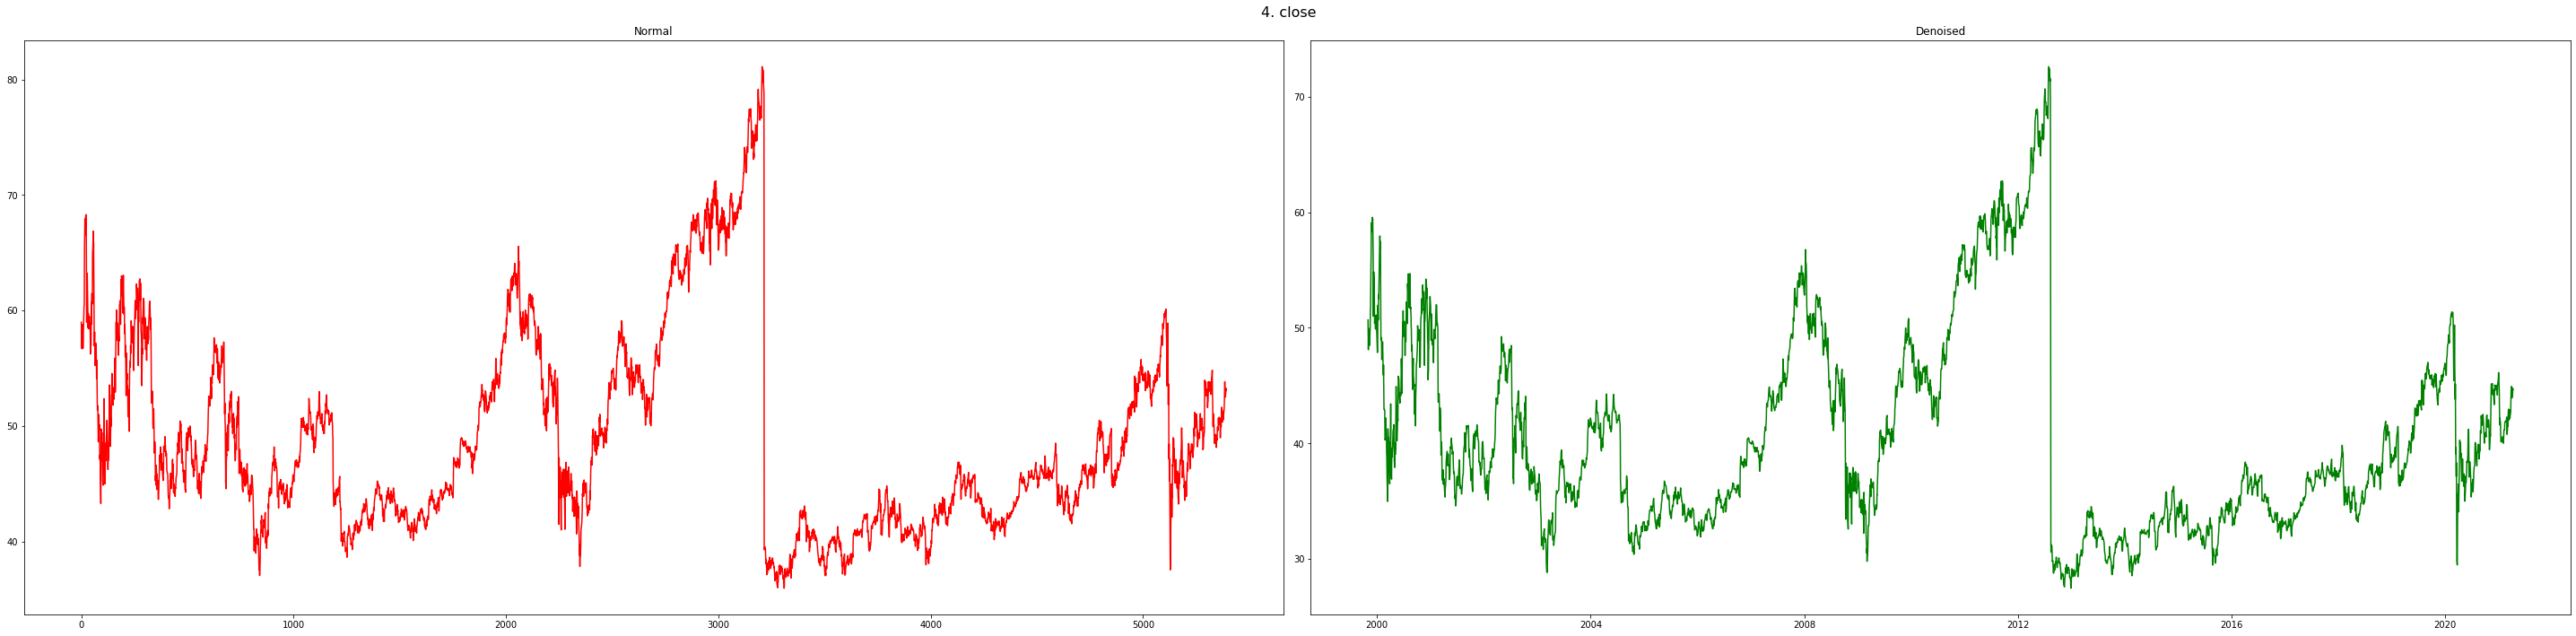

            1. open  2. high  3. low  4. close   5. volume  1. open wlt  \
date                                                                      
2021-04-08    53.17   53.380  52.970     53.12   9693904.0    44.753882   
2021-04-07    53.28   53.500  53.120     53.28  10062687.0    44.629619   
2021-04-06    53.04   53.650  52.900     53.19  15614268.0    44.485943   
2021-04-05    52.35   53.215  52.290     52.81  16368724.0    44.273810   
2021-04-01    52.96   53.150  52.455     52.51  15834732.0    44.211633   

            2. high wlt  3. low wlt  4. close wlt  
date                                               
2021-04-08    44.792347   44.596240     44.620570  
2021-04-07    44.959016   44.566831     44.729379  
2021-04-06    45.097076   44.485314     44.776030  
2021-04-05    44.728419   44.110536     44.310034  
2021-04-01    44.420572   43.839328     43.937594  


In [47]:
# Apply Wavelet transformation on the timeseries to denoise it. We will use the coif3 transformation
for column in df:
    if column == '5. volume':
        break
    (ca, cd) = pywt.dwt(df[column], "coif3")                
    cat = pywt.threshold(ca, np.std(ca), mode="soft")                
    cdt = pywt.threshold(cd, np.std(cd), mode="soft")                
    dft = pywt.idwt(cat, cdt, "coif3")
    df[column+' wlt'] = dft[:len(dft)-1]

#wave_data = [x for x in wave_data for _ in range(2)] #Adjust size to original size
#wave_data = wave_data[:len(wave_data)-1]
for column in df:
    if column == '5. volume':
        break
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(40,10))
    ax[0].plot(df[column][::-1].to_numpy(), 'r')
    ax[0].set_title('Normal')
    ax[1].plot(df[column+' wlt'], 'g')
    ax[1].set_title('Denoised')

    fig.suptitle(column, fontsize=16)
    plt.tight_layout()
    plt.show()

print(df.head())

In [ ]:
# Getting stock news and calculate the polarity 
api_key = ''
sn = StockNews('GOOGL', wt_key=api_key)
df = sn.summarize()

AxesSubplot(0.125,0.125;0.775x0.755)
[[[0.38282292 0.37816006 0.3847088  0.38003221]
  [0.38005605 0.38186119 0.38404956 0.38244407]
  [0.37685693 0.38492699 0.38222228 0.38347813]
  ...
  [0.30580727 0.30082362 0.29919626 0.29483443]
  [0.31311014 0.31146944 0.31366896 0.31112808]
  [0.31749678 0.31936024 0.31786513 0.31863214]]

 [[0.38005605 0.38186119 0.38404956 0.38244407]
  [0.37685693 0.38492699 0.38222228 0.38347813]
  [0.37213351 0.37674046 0.37382123 0.37314888]
  ...
  [0.31311014 0.31146944 0.31366896 0.31112808]
  [0.31749678 0.31936024 0.31786513 0.31863214]
  [0.319412   0.32327902 0.31652936 0.31911946]]

 [[0.37685693 0.38492699 0.38222228 0.38347813]
  [0.37213351 0.37674046 0.37382123 0.37314888]
  [0.37074907 0.36990429 0.36774183 0.36489338]
  ...
  [0.31749678 0.31936024 0.31786513 0.31863214]
  [0.319412   0.32327902 0.31652936 0.31911946]
  [0.31471415 0.32088135 0.30951207 0.32593859]]

 [[0.37213351 0.37674046 0.37382123 0.37314888]
  [0.37074907 0.36990429 0.

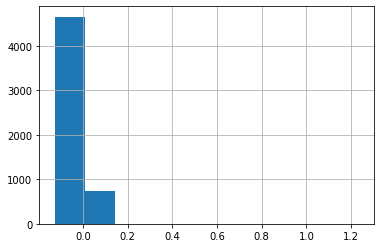

In [55]:
# Transform data 
# 1. calculate return
df['PrevClose'] = df['4. close wlt'].shift(1)
df['Return'] = (df['4. close wlt'] - df['PrevClose']) / df['PrevClose']
print(df['Return'].hist())

# 2. Define label and input
data = df[['1. open wlt', '2. high wlt', '3. low wlt', '4. close wlt']].values
targets = df['Return'].values

T = 60 
D = data.shape[1]
N = len(data) - T

# 3. Scale Data 
N_train = int(len(data) * 0.7)
scaler = MinMaxScaler()
scaler.fit(data[:N_train + T - 1])
data = scaler.transform(data)

# 4. Build Train and test set
X_train = np.zeros((N_train, T, D))
Y_train = np.zeros(N_train)

for t in range(N_train):
  X_train[t, :, :] = data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

X_test = np.zeros((N - N_train, T, D))
Y_test = np.zeros(N - N_train)

for u in range(N - N_train):
  t = u + N_train
  X_test[u, :, :] = data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

print(X_train[:5], Y_train[:5])

In [66]:
# Building the LSTM Model  
i = Input(shape=(T, D))
x = LSTM(64, return_sequences=True)(i)
x = Attention(32)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=80,
  validation_data=(X_test, Y_test),
)

Epoch 1/80
118/118 [==============================] - 7s 29ms/step - loss: 0.6919 - accuracy: 0.5191 - val_loss: 0.6936 - val_accuracy: 0.4981
Epoch 2/80
118/118 [==============================] - 3s 23ms/step - loss: 0.6918 - accuracy: 0.5270 - val_loss: 0.6938 - val_accuracy: 0.4981
Epoch 3/80
118/118 [==============================] - 3s 22ms/step - loss: 0.6908 - accuracy: 0.5413 - val_loss: 0.6927 - val_accuracy: 0.4981
Epoch 4/80
118/118 [==============================] - 3s 22ms/step - loss: 0.6892 - accuracy: 0.5405 - val_loss: 0.6923 - val_accuracy: 0.4981
Epoch 5/80
118/118 [==============================] - 3s 22ms/step - loss: 0.6899 - accuracy: 0.5460 - val_loss: 0.6917 - val_accuracy: 0.4981
Epoch 6/80
118/118 [==============================] - 3s 21ms/step - loss: 0.6897 - accuracy: 0.5378 - val_loss: 0.6920 - val_accuracy: 0.4981
Epoch 7/80
118/118 [==============================] - 3s 22ms/step - loss: 0.6908 - accuracy: 0.5230 - val_loss: 0.6916 - val_accuracy: 0.4981

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 60, 4)]      0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 60, 64)       17664       input_8[0][0]                    
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 64)           0           lstm_7[0][0]                     
__________________________________________________________________________________________________
attention_score_vec (Dense)     (None, 60, 64)       4096        lstm_7[0][0]                     
____________________________________________________________________________________________

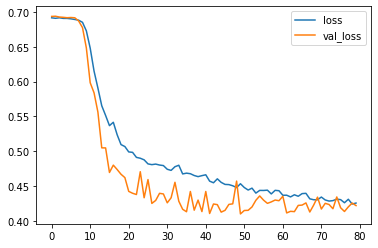

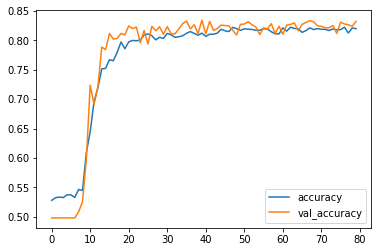

[1, 1999]


In [69]:
# Performance Analysis
print(model.summary())

# Plot loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

# Try some predictions
preds = [0, 0]
for i in range(0, 2000, 1):
    p = model.predict(df.iloc[i:i+60, :4].values.reshape(1, 60, 4))[0,0]
    preds[int(p)] += 1
print(preds)